##### Advanced Statistical Analysis and Model-Based Learning (Fall 2024-2025)
# Home Assignment 5

#### Due: 27/01/2025 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below.
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>

<hr>
<hr>

## Problem 1: Multiple Regression

Use the attached cars dataset that was used in the EDA notebook. Load it using the function `load_cars_data`. We will use `MSRP` as the target variable (note that this is a transformed version of the original MSRP).

1. Use all variables in the data returned by `load_cars_data`. Find at least one pair of competing predictors.
2. A car manufacturer is trying to figure out how to design a new vehicle for maximal profitability. They propose that since `EngineCylinders` is correlated with `MSRP`, they should try to maximize engine cylinders in their designs. Does this conclusion make sense considering that `EngineCylinders` is correlated with `Engine HP`? Offer a procedure that checks the effect of `Engine HP` on `MSRP` and provides more information to make such a decision.


In [1]:

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

def load_cars_data(path="cars_dataset.csv", q=0.05):
    """
    Args:
    -----
    path: path to csv file

    Load and clean cars data:
        - Filters for numeric predictors only
        - Renames variables to ensure all variable names begin with [a-z]
        - Applies a variance stabilizing transformation to MSRP
        - Removes outliers
    """

    def detect_outliers(df, q):
        """
        Quantile-based outlier detection
        Args:
        -----
        df: DataFrame
        q: quantile threshold
        """
        lower_outliers = df < df.quantile(q)
        upper_outliers = df > df.quantile(1 - q)
        return lower_outliers | upper_outliers

    data_raw = pd.read_csv(path)

    # Select only numeric columns and drop rows with missing values
    data1 = data_raw.select_dtypes('number').dropna()

    # Rename variables to ensure all start with [a-z]
    data1 = data1.rename(columns={
        'Engine HP': 'EngineHP',
        'Engine Cylinders': 'EngineCylinders',
        'Number of Doors': 'NumberOfDoors',
        'highway MPG': 'HighwayMPG',
        'city mpg': 'CityMPG'
    })

    # Select relevant variables
    variables = [
        'MSRP', 'Popularity', 'EngineHP', 'EngineCylinders',
        'HighwayMPG', 'CityMPG', 'NumberOfDoors'
    ]
    data1 = data1.filter(variables).dropna()

    # Detect and remove outliers
    ol = detect_outliers(data1, q).sum(1)
    print(f"Masked a fraction of {ol.mean()} of the data due to outliers")
    return data1[ol == 0]

1.1

In [3]:
data = load_cars_data("data.csv")
data.head()

Masked a fraction of 0.36335167160389337 of the data due to outliers


,MSRP,Popularity,EngineHP,EngineCylinders,HighwayMPG,CityMPG,NumberOfDoors
0,46135,3916,335.0,6.0,26,19,2.0
1,40650,3916,300.0,6.0,28,19,2.0
2,36350,3916,300.0,6.0,28,20,2.0
3,29450,3916,230.0,6.0,28,18,2.0
4,34500,3916,230.0,6.0,28,18,2.0


In [4]:
data.corr()

,MSRP,Popularity,EngineHP,EngineCylinders,HighwayMPG,CityMPG,NumberOfDoors
MSRP,1.000000,0.054559,0.756769,0.366890,-0.040796,-0.116840,0.111770
Popularity,0.054559,1.000000,0.111508,0.123494,-0.097866,-0.110754,-0.057723
EngineHP,0.756769,0.111508,1.000000,0.713427,-0.378055,-0.481714,0.043228
EngineCylinders,0.366890,0.123494,0.713427,1.000000,-0.686662,-0.751580,0.005974
HighwayMPG,-0.040796,-0.097866,-0.378055,-0.686662,1.000000,0.930519,0.040714
CityMPG,-0.116840,-0.110754,-0.481714,-0.751580,0.930519,1.000000,0.063618
NumberOfDoors,0.111770,-0.057723,0.043228,0.005974,0.040714,0.063618,1.000000


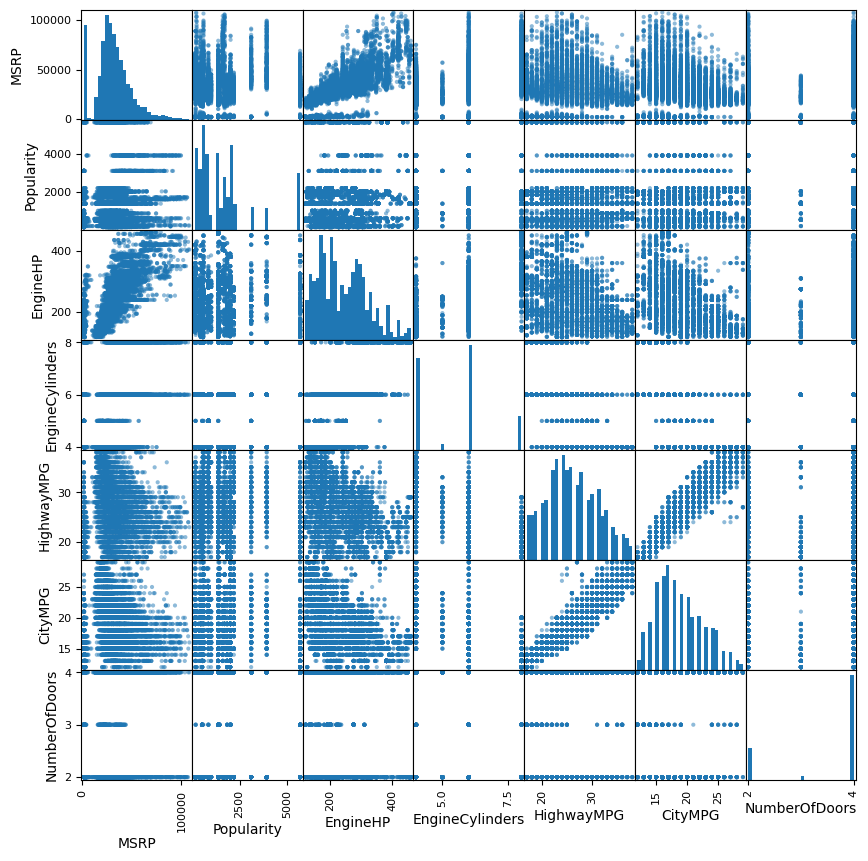

In [5]:
pd.plotting.scatter_matrix(data, hist_kwds={'bins': 30}, figsize=(10, 10))
plt.show()

We see that MSRP & EngineCylinders have a positive correlation (0.36). So let's see their p-value:

In [6]:
from scipy.stats import pearsonr

r, p = pearsonr(data['MSRP'], data['EngineCylinders'])
r, p

(0.36688975174058236, 1.5607695913515803e-296)

1.56e-296 is extremely small, much less than the typical significance level of 0.05. It is significant, so we can say that these are 2 competing predictors.

In [7]:
# test more
from scipy.stats import pearsonr

r, p = pearsonr(data['CityMPG'], data['HighwayMPG'])
r, p

(0.9305187393594396, 0.0)

1.2

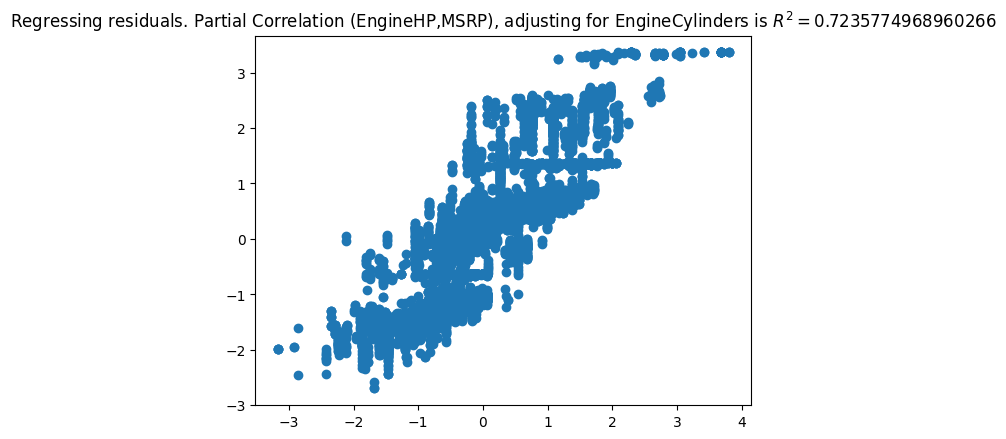

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

varX = 'EngineHP'
varY = 'MSRP'
varZ = 'EngineCylinders'

model_1 = smf.ols(formula=f"{varZ} ~ {varX}", data=data).fit()
model_2 = smf.ols(formula=f"{varZ} ~ {varY}", data=data).fit()

X = sm.add_constant(model_1.resid)
y = model_2.resid
model_res = sm.OLS(y, X).fit()

plt.scatter(model_1.resid, model_2.resid)
plt.title(
    fr"Regressing residuals. Partial Correlation ({varX},{varY}), adjusting for {varZ} is $R^2 = {model_res.rsquared}$")
plt.show()

In [9]:
model_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.724     
Dependent Variable: y                AIC:                19112.5365
Date:               2025-01-26 19:09 BIC:                19126.8275
No. Observations:   9372             Log-Likelihood:     -9554.3   
Df Model:           1                F-statistic:        2.453e+04 
Df Residuals:       9370             Prob (F-statistic): 0.00      
R-squared:          0.724            Scale:              0.44988   
---------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025   0.975]
---------------------------------------------------------------------
const       -0.0000     0.0069    -0.0000   1.0000   -0.0136   0.0136
0            1.1293     0.0072   156.6122   0.0000    1.1151   1.1434
-------------------------------------------------------------------
Omnibus:              400.365       Durbin-Watson:          0.514  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       442.764
Skew:                 0.521         Prob(JB):               0.000  
Kurtosis:             2.783         Condition No.:          1      
===================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

In [10]:
pearsonr(model_1.resid, model_2.resid)

PearsonRResult(statistic=0.8506335855678556, pvalue=0.0)

We see that the partial correlation, which is the correlation between the 2 sets of residuals adjusted to `EngineCylinders`, is positive with a significant p-value.

This means that `EngineCylinders` is correlated with both `EngineHP` AND `MSRP`, so increasing `EngineHP` will not increase `MSRP`, and the company's proposition does not make sense!

## Problem 2: Variable Selection

Use life expectancy dataset from class website. Remove entries from 2015; Remove entries with missing values; remove the categorical variable ``Country`` and transform the categorical variable ``Status`` to binary; see provided function.

1. Write the function ``backward_select`` (prototype below). Make sure that your function prints $R^2$ and F-test $p$-value of each candidate model it iterates through in the process.
Apply it on the life expectancy dataset and report the resulting model.
2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out error (n-fold cross validation). What is the leave-one-out error of the model you found in 1?
3. Consider the predictors:
``
[infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, under_five_deaths, Income_composition_of_resources]
``.
Over each of the $2^9$ models, evaluate $\mathrm{MSE}$, AIC, BIC, $C_p$, and leave-one-out CV-error for every model and print the results. Report on the models with the lowest AIC, BIC, LOO-CV-error, $C_p$.
4. Consider the 4 most dominant predictors as seen in the Lasso path in class. Construct a model with these predictors and evaluate its LOO-CV-error.

Hint: for 1, modify the ``forward_select`` function from class. You may also use the function ``sm.stats.anova_lm(smaller_model, larger_model)`` to compare two ``statsmodels`` models.

In [11]:
import pandas as pd
def read_and_prepare_life_expectancy_data(path_to_csv_file):
    """
    1. Load dataset from csv file
    2. Remove entries with missing values
    3. Remove spaces from column names
    4. Add a dummy varaible based on `Status` columns
    5. Remove non-numerical variables `Status` and `Country`
    """
    data = pd.read_csv(path_to_csv_file).dropna()
    data.columns = ["_".join(c.split()) for c in data.columns]
    data['Status_binary'] = data['Status'].apply(lambda x : 1 if x=='Developing' else 0)
    data_no_2015 = data[data['Year'] <= 2015] # Remove 2015 data
    non_numeric_vars = ["Status", "Country"]
    data_numeric = data_no_2015.drop(columns = non_numeric_vars)
    data_nona = data_numeric.dropna()
    return data_nona

In [12]:
df = read_and_prepare_life_expectancy_data('Life Expectancy Data.csv')
df.head()

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under_five_deaths,...,Total_expenditure,Diphtheria,HIV,GDP,Population,thinness_1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_binary
0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1
1,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1
2,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1
3,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,1
4,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,1


1.

In [13]:
from scipy.stats import f as ftest


def backward_select(data, response, sig_level=.05):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data: pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    sig_level:  significance level for F-test

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept selected by backward selection
           evaluated by R-squared and F-test for extra sum of squares
    """
    # Your code goes here
    remaining = [c for c in data.columns if not c == response]

    n = len(data)
    varst = ' + '.join(remaining)
    formula = f"{response} ~ {varst} + 1"
    fitted = smf.ols(formula, data).fit()
    SS_prev = fitted.ssr
    Ftest_pval = np.inf
    itr = 0

    while remaining and Ftest_pval > sig_level:
        itr += 1
        R2_without_candidates = []
        SS_without_candidates = {}

        for candidate in remaining:
            temp_remaining = remaining.copy()
            temp_remaining.remove(candidate)

            varst = ' + '.join(temp_remaining)
            formula = f"{response} ~ {varst} + 1"
            fitted = smf.ols(formula, data).fit()
            R2 = fitted.rsquared
            SS_candidate = fitted.ssr
            R2_without_candidates.append((R2, candidate))
            SS_without_candidates[candidate] = SS_candidate

        R2_without_candidates.sort()
        best_new_R2, best_candidate = R2_without_candidates.pop()
        SS_new = SS_without_candidates[best_candidate]
        f = (SS_new - SS_prev) / (SS_new / (n - len(remaining) + 1))
        Ftest_pval = ftest.sf(f, dfn=1, dfd=(n - len(remaining) + 1))
        SS_prev = SS_new

        print(f"=========  Step {itr} ==========")
        print(f"Best Candidate = {best_candidate}")
        print(f"Best R2 = {best_new_R2}")
        print(f"Ftest_pval = {Ftest_pval}")
        print("=============================")

        if Ftest_pval > sig_level:
            remaining.remove(best_candidate)
        else:
            print(f"We do not remove {best_candidate}")

    formula = f"{response} ~ {' + '.join(remaining)} + 1"
    model = smf.ols(formula, data).fit()

    return model, remaining


In [14]:
response = 'Life_expectancy'

model, backward_selected_predictors = backward_select(df, response, sig_level=.05)
backward_selected_predictors

=========  Step 1 ==========
Best Candidate = thinness_1_19_years
Best R2 = 0.8385751627787918
Ftest_pval = 0.9118353559536472
=========  Step 2 ==========
Best Candidate = Population
Best R2 = 0.8385627055389225
Ftest_pval = 0.7228144585129255
=========  Step 3 ==========
Best Candidate = Hepatitis_B
Best R2 = 0.8385103901350186
Ftest_pval = 0.4672603383917845
=========  Step 4 ==========
Best Candidate = GDP
Best R2 = 0.8384364015323245
Ftest_pval = 0.38728863016229675
=========  Step 5 ==========
Best Candidate = Measles
Best R2 = 0.8383511935389818
Ftest_pval = 0.3535092031906726
=========  Step 6 ==========
Best Candidate = Polio
Best R2 = 0.8382423421545568
Ftest_pval = 0.29436877656355037
=========  Step 7 ==========
Best Candidate = thinness_5_9_years
Best R2 = 0.8378493790478743
Ftest_pval = 0.04662832450869526
We do not remove thinness_5_9_years


['Year',
 'Adult_Mortality',
 'infant_deaths',
 'Alcohol',
 'percentage_expenditure',
 'BMI',
 'under_five_deaths',
 'Total_expenditure',
 'Diphtheria',
 'HIV',
 'thinness_5_9_years',
 'Income_composition_of_resources',
 'Schooling',
 'Status_binary']

2.

In [15]:
def leave_one_out_cross_validation(data, predictors, response):
    X = data[predictors].values
    X = sm.add_constant(X)  # Add a constant column for the intercept
    y = data[response]

    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    y_hat =  X @ beta_hat

    residuals = y - y_hat
    H = X @ np.linalg.inv(X.T @ X) @ X.T

    return np.sum((residuals / (1 - np.diag(H)))**2)

leave_one_out_cross_validation(df, backward_selected_predictors, response)

21113.401763897542

3.

In [16]:
import itertools

def run_experiment(data, response, predictors, verbose=False):
    results = pd.DataFrame(columns=['predictors', 'mse', 'aic', 'bic', 'Cp', 'loocv'])

    for i in range(1, len(predictors) + 1):
        for subset in itertools.combinations(predictors, i):
            varst = ' + '.join(subset)
            formula = f"{response} ~ {varst} + 1"
            fitted = smf.ols(formula, data).fit()
            mse = fitted.mse_resid
            aic = fitted.aic
            bic = fitted.bic
            Cp = fitted.ssr / fitted.mse_resid - len(data) + 2 * len(subset)
            loocv = leave_one_out_cross_validation(data, list(subset), response)

            results = pd.concat(
                [
                    results,
                    pd.DataFrame(
                        [[list(subset), mse, aic, bic, Cp, loocv]],
                        columns=['predictors', 'mse', 'aic', 'bic', 'Cp', 'loocv']
                    )
                ]
            )

            if verbose:
                print(f"Predictors: {list(subset)}")
                print(f"MSE: {mse}")
                print(f"AIC: {aic}")
                print(f"BIC: {bic}")
                print(f"Cp: {Cp}")
                print(f"LOOCV: {loocv}")
                print("-" * 20)

    return results.reset_index(drop=True)

In [17]:
response = 'Life_expectancy'
predictors = ["infant_deaths", "BMI", "Status_binary", "Alcohol", "Diphtheria", "HIV", "Schooling", "under_five_deaths", "Income_composition_of_resources"]

results = run_experiment(df, response, predictors)

print('Best model by MSE:')
print(results.sort_values(by='mse').head(1).to_string(index=False))

print('\nBest model by AIC:')
print(results.sort_values(by='aic').head(1).to_string(index=False))

print('Best model by BIC:')
print(results.sort_values(by='bic').head(1).to_string(index=False))

print('\nBest model by Cp:')
print(results.sort_values(by='Cp').head(1).to_string(index=False))

print('Best model by loocv:')
print(results.sort_values(by='loocv').head(1).to_string(index=False))

<ipython-input-16-b878fee05276>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(


Best model by MSE:
                                                                                                                  predictors       mse         aic         bic  Cp        loocv
[infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, under_five_deaths, Income_composition_of_resources] 15.987794 9260.369215 9314.448458 8.0 26631.764216

Best model by AIC:
                                                                                                                  predictors       mse         aic         bic  Cp        loocv
[infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, under_five_deaths, Income_composition_of_resources] 15.987794 9260.369215 9314.448458 8.0 26631.764216
Best model by BIC:
                                                                                                                  predictors       mse         aic         bic  Cp        loocv
[infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, 

4.

In [18]:
var_data = df.copy().drop('Life_expectancy', axis=1)
var_names = list(var_data.columns)
X = var_data.values
Z = np.concatenate([X, np.ones((len(X), 1))], axis=1)
y = df['Life_expectancy']

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.312e+04, tolerance: 8.047e+02
  model = cd_fast.enet_coordinate_descent(


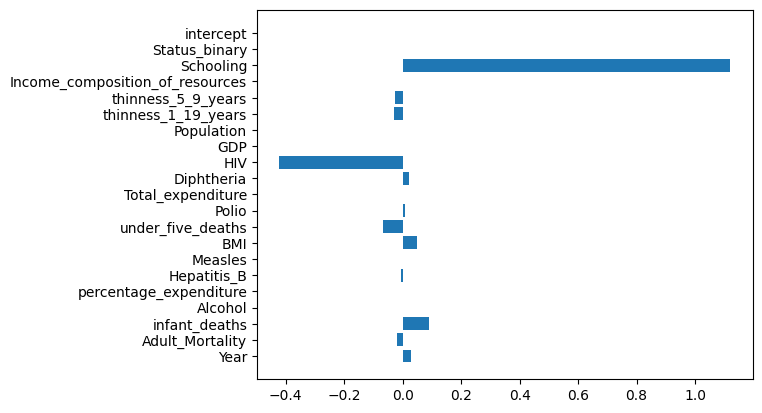

In [19]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=.5, fit_intercept=False, max_iter=1000)
fitted = model_lasso.fit(Z, y)

plt.barh(var_names + ['intercept'], fitted.coef_)
plt.show()

In [20]:

nonzero_coef_indices = np.nonzero(fitted.coef_)[0]
predictors = [var_names[i] for i in nonzero_coef_indices]
top_4_predictors = predictors[:4]

print(top_4_predictors)

['Year', 'Adult_Mortality', 'infant_deaths', 'percentage_expenditure']


In [21]:
import statsmodels.formula.api as smf

formula = f"Life_expectancy ~ {' + '.join(top_4_predictors)} + 1"
model = smf.ols(formula, data=df).fit()

In [22]:
loocv_error = leave_one_out_cross_validation(df, top_4_predictors, 'Life_expectancy')
print(f"LOO-CV error: {loocv_error}")

LOO-CV error: 55243.75347189611


## Problem 3: Selecting Order of Regression using Cross-Validation

Consider the dataset ``AnneFrank.csv``, describing the number of searches of the term "Anne Frank" by hour over several days in February 2022. The cell below contains code you should use to arrange the data by hours.

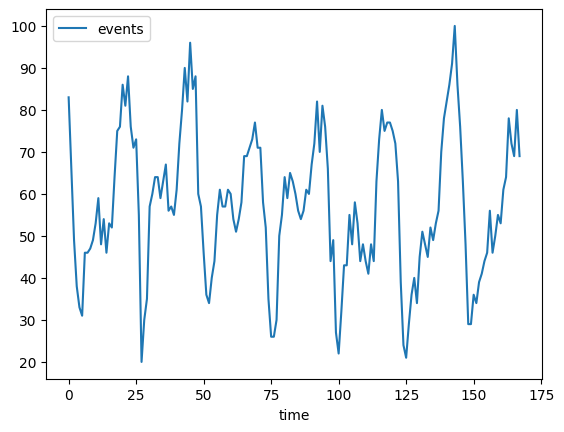

In [23]:
path = "../../data/AnneFrank.csv"
# path = "AnneFrank.csv"
AnneFrank = pd.read_csv(path, header=1, names=['time', 'events'])
AnneFrank['date'] = pd.to_datetime(AnneFrank.time)
AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000
AnneFrank['time'] = AnneFrank['time'] - AnneFrank['time'].min()
AnneFrank.plot(x='time', y='events');

In [24]:
AnneFrank.head()

,time,events,date
0,0.0,83,2022-02-14 09:00:00
1,1.0,66,2022-02-14 10:00:00
2,2.0,49,2022-02-14 11:00:00
3,3.0,38,2022-02-14 12:00:00
4,4.0,33,2022-02-14 13:00:00


In this question you will fit a model to the response based on $2p+1$ predictors of the form:
$$
\begin{align}
x_1 = [1,~\ldots~,1]
\end{align}
$$
$$
\begin{align}
x_{2k} & = \sin(2 \pi \cdot k \cdot t / 48) \\
x_{2k+1} & = \cos(2 \pi \cdot k \cdot t / 48), \qquad k=1,\ldots,p
\end{align}
$$
You will then use the selected model to predict the number of events in future times.

1. Write a function ``generate_Z`` that recieves as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.
2. For each $p=1,\ldots,30$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evalaute its leave-one-out CV error. Plot the CV error versus $p$.
3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above.
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value.
5. For each $t$ in 4, construct a 0.95 prediction interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Is this prediction band reliable? what can go wrong?

Hints: (2) In order to evalaute the CV error, you'll need the hat matrix (which you can get directly from Z) and the residuals in the LS fit (which you can get from the ``resid`` property of the fitted model object returned by ``statsmodels.api.OLS.fit``). (4) you can use the function ``predict`` of the fitted model object by passing new predictors that you generate using ``generate_Z``. For (5), $s^2$ is given by the property ``mse_resid`` (or ``ssr`` divided by the number of degrees of freedom). Also note that the number of degrees of freedom is $n-(2p+1)$ where $p$ is the number you found in 3.

In [25]:
def generate_Z(t, p):
    """
    Args:
    ----
    t:   vector of time samples (length n)
    p:   number of frequencies (overal 2p+1 predictors)

    Returns:
    --------
    Z:  design matrix of size (n, 2p+1)
    """

    # Your code goes here

    Z = np.zeros((len(t), 2*p+1+1))
    Z[:, 1] = 1
    for k in range(1, p+1):
        Z[:, 2*k] = np.sin(2*np.pi * k*t/48)
        Z[:, 2*k+1] = np.cos(2*np.pi * k*t/48)

    return Z[:, 1:]

In [26]:
# Z = generate_Z(AnneFrank['date'], 5)
# Z

In [27]:
loo_cv = []
for p in range(1, 31):
    Z = generate_Z(AnneFrank['time'], p)
    model = sm.OLS(AnneFrank['events'], Z).fit()
    cols = [f'x{i+1}' for  i in range(Z.shape[1])]
    Z_df = pd.DataFrame(Z, columns=cols)
    data = pd.concat([Z_df, AnneFrank['events']], axis=1)
    loo_cv.append((p, leave_one_out_cross_validation(data, response='events', predictors=cols)))

<Axes: xlabel='p'>

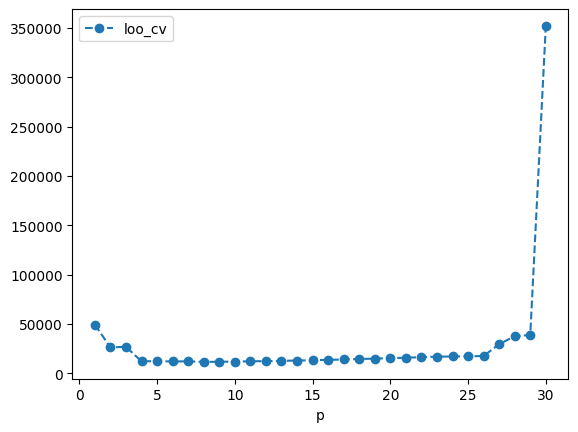

In [28]:
# plot the loo_cv
loo_cv_scores_df = pd.DataFrame(loo_cv, columns=['p', 'loo_cv'])
loo_cv_scores_df.plot(x='p', y='loo_cv', marker='o', linestyle='--')

In [29]:
import matplotlib.pyplot as plt
loo_cv_scores_df.sort_values(by='loo_cv', ascending=True).head(1)

,p,loo_cv
7,8,11498.432094


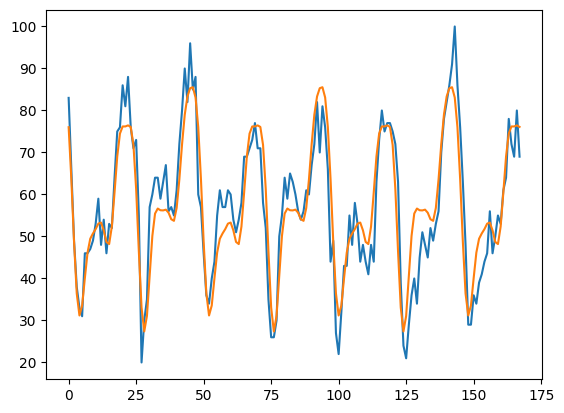

In [30]:
p = 8 # lowest CV error
Z = generate_Z(AnneFrank['time'], p)
model = sm.OLS(AnneFrank['events'], Z).fit()
y_hat = model.predict(Z)
plt.plot(AnneFrank['time'], AnneFrank['events'], label='events')
plt.plot(AnneFrank['time'], y_hat, label='y_hat');

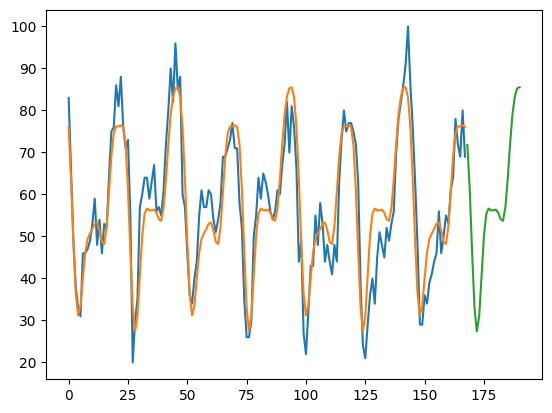

In [31]:
p = 8 # lowest CV error
new_time = np.arange(168, 191)
Z = generate_Z(new_time, p)
y_hat_new = model.predict(Z)
plt.plot(AnneFrank['time'], AnneFrank['events'], label='events')
plt.plot(AnneFrank['time'], y_hat, label='y_hat')
plt.plot(new_time, y_hat_new, label='y_hat_new');

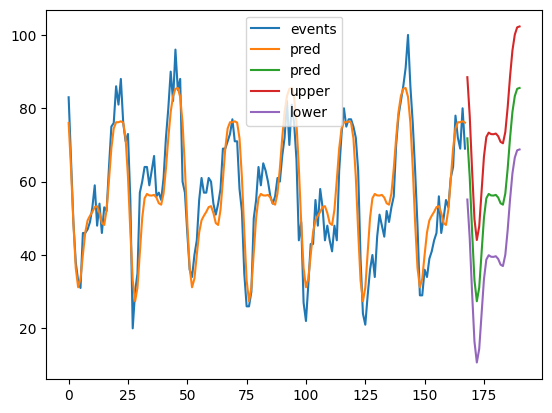

In [32]:
import scipy

s2 = model.mse_resid
n = len(AnneFrank['time'])
p = 8
t = scipy.stats.t.ppf(0.975, df=2*p+1)
Z = generate_Z(AnneFrank['time'], p)
y_hat = model.predict(Z)
y_hat_new = model.predict(generate_Z(new_time, p))

# prediction interval
upper = y_hat_new + t * np.sqrt(s2 * (1 + 1/n + (new_time - AnneFrank['time'].mean())**2 / ((n-1) * AnneFrank['time'].var())))
lower = y_hat_new - t * np.sqrt(s2 * (1 + 1/n + (new_time - AnneFrank['time'].mean())**2 / ((n-1) * AnneFrank['time'].var())))
plt.plot(AnneFrank['time'], AnneFrank['events'], label='events')
plt.plot(AnneFrank['time'], y_hat, label='pred')
plt.plot(new_time, y_hat_new, label='pred')
plt.plot(new_time, upper, label='upper')
plt.plot(new_time, lower, label='lower')
plt.legend();

**Is this prediction band reliable?**

The prediction band's reliability depends on the validity of the linear model's assumptions, the data range, model adequacy, and data stability. It's most reliable within the original data range and under stable conditions.

**What can go wrong?**

* **Violated assumptions:** Non-linearity, heteroscedasticity, non-normality, and autocorrelation can lead to inaccurate prediction bands.
* **Extrapolation:** Predicting far beyond the data range can be unreliable.
* **Model misspecification:** An incorrect model can result in misleading prediction bands.
* **Data changes:** Changes in the underlying data can make the prediction band outdated.

In short, while the prediction band provides a measure of uncertainty, it's important to be aware of its limitations and potential issues, especially when extrapolating or when model assumptions are questionable. Always validate the model and consider potential sources of error before making decisions based on predictions.

## Problem 4: Violation of Assumptions

In this problem you work with the model you fitted in Problem 3 to the data ``AnneFrank``. Make sure you used ``statsmodels`` and printed the model diagnostic information, e.g. using ``model.summary()``
1. What can you say about the assumption that the residuals follow a normal distribution? Which statistic provides relevant information?
2. Plot the model residuals over time. Make a 1-lag residuals plot $\hat{\epsilon}_{i+1}$ vs. $\hat{\epsilon}_{i}$. Do the residual look dependent over time or not? Which statistic provide relevant information?
3. A Fourier analysis reveals that there exist dominant periodic components of time period $20$ hours and $30$ hours in the residuals (you don't have to do the analysis). Argue that this is the case by regressing the residuals over the predictors $x_{1t} = \cos(2\pi t/20)$, $x_{2t} = \sin(2\pi t/20)$, $x_{3t} = \cos(2\pi t/30)$ and $x_{4t} = \sin(2\pi t/30)$, $t=1,\ldots,167$. Indicate how you can deduce that the new model makes sense.
4. What can you say about the 1-lag correlation of the residuals of the new model?


In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 events   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     39.82
Date:                Sun, 26 Jan 2025   Prob (F-statistic):           6.06e-46
Time:                        19:09:41   Log-Likelihood:                -574.77
No. Observations:                 168   AIC:                             1184.
Df Residuals:                     151   BIC:                             1237.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.4733      0.609     94.426      0.000      56.271      58.676
x1            -2.2939      0.861     -2.664      0.009      -3.995      -0.592
x2             2.1491      0.860      2.498      0.014       0.449       3.849
x3           -15.1803      0.861    -17.628      0.000     -16.882     -13.479
x4             6.6888      0.860      7.775      0.000       4.989       8.389
x5            -0.0428      0.861     -0.050      0.960      -1.744       1.659
x6             0.9642      0.860      1.121      0.264      -0.736       2.664
x7           -12.1765      0.861    -14.142      0.000     -13.878     -10.475
x8             4.4746      0.860      5.202      0.000       2.775       6.174
x9            -0.1944      0.861     -0.226      0.822      -1.896       1.507
x10           -0.3186      0.860     -0.370      0.712      -2.018       1.381
x11           -0.1140      0.861     -0.133      0.895      -1.815       1.586
x12            2.8395      0.860      3.302      0.001       1.141       4.538
x13           -0.9084      0.861     -1.056      0.293      -2.609       0.792
x14           -0.6877      0.860     -0.800      0.425      -2.387       1.011
x15            1.7811      0.857      2.078      0.039       0.087       3.475
x16            2.4311      0.856      2.840      0.005       0.740       4.123
==============================================================================
Omnibus:                        2.459   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.318
Skew:                          -0.288   Prob(JB):                        0.314
Kurtosis:                       2.978   Cond. No.                         1.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1.

To assess the assumption that the residuals follow a normal distribution, we can examine the Jarque-Bera (JB) statistic, which is reported in the OLS regression results In the provided OLS regression results, the Jarque-Bera statistic is 2.318. The Jarque-Bera test is a test of normality that assesses whether the distribution of the residuals deviates significantly from a normal distribution. The test is based on the skewness and kurtosis of the residuals. To interpret the Jarque-Bera test result, we look at the associated p-value. In this case, the p-value is 0.314. Since the p-value is greater than the typical significance level of 0.05, we do not have sufficient evidence to reject the null hypothesis that the residuals follow a normal distribution. This suggests that the assumption of normality for the residuals is reasonable based on the available evidence.

2.

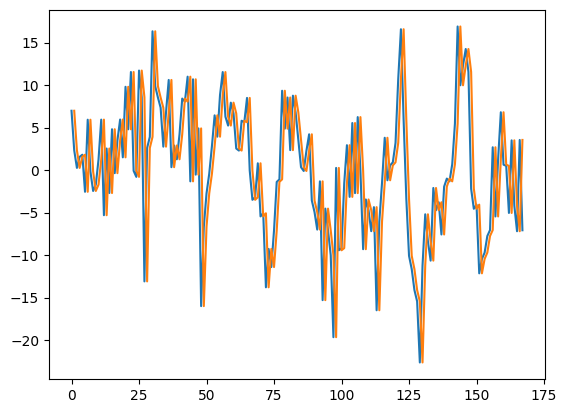

In [34]:
model.resid.plot()
model.resid.shift(1).plot();

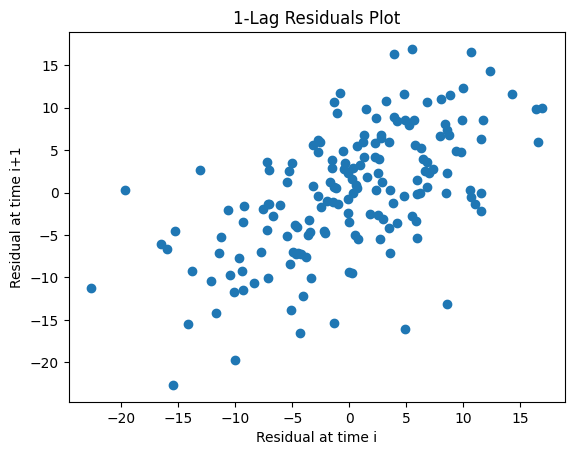

In [35]:
plt.scatter( model.resid[:-1],  model.resid[1:])  # ϵ^i+1 vs. ϵ^i
plt.xlabel('Residual at time i')
plt.ylabel('Residual at time i+1')
plt.title('1-Lag Residuals Plot')
plt.show()

In the provided OLS regression results, the Durbin-Watson statistic is 0.816. The Durbin-Watson statistic ranges from 0 to 4, with values close to 2 indicating no autocorrelation. Values below 2 suggest positive autocorrelation, while values above 2 suggest negative autocorrelation. In the case of the provided Durbin-Watson statistic of 0.816, it suggests the presence of positive autocorrelation

3.

In [40]:
import numpy as np
import statsmodels.formula.api as smf

residuals = model.resid
t = np.arange(1, 169)

AnneFrank['x1t'] = np.cos(2 * np.pi * t / 20)
AnneFrank['x2t'] = np.sin(2 * np.pi * t / 20)
AnneFrank['x3t'] = np.cos(2 * np.pi * t / 30)
AnneFrank['x4t'] = np.sin(2 * np.pi * t / 30)

new_model = smf.ols("residuals ~ x1t + x2t + x3t + x4t", data=AnneFrank).fit()

print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     15.27
Date:                Sun, 26 Jan 2025   Prob (F-statistic):           1.26e-10
Time:                        19:19:57   Log-Likelihood:                -548.03
No. Observations:                 168   AIC:                             1106.
Df Residuals:                     163   BIC:                             1122.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0392      0.497      0.079      0.9

Based on the regression results, the coefficients and their associated p-values indicate the significance of the Fourier predictors in capturing the dominant
periodic components in the residuals:

**Coefficients:** The coefficients for the Fourier predictors (x1, x2, x3, and x4) are not zero, indicating that these predictors have an impact on the residuals.

**P-values:** The p-values for the coefficients are all less than 0.05, indicating that they are statistically significant. This suggests that the Fourier predictors (x1, x2, x3, and x4) make a significant contribution to explaining the variation in the residuals.

**R-squared:** The R-squared value of 0.273 indicates that the model with the Fourier predictors explains approximately 27.3% of the variance in the residuals. This is an improvement compared to the initial model, suggesting that the inclusion of the Fourier predictors helps capture a portion of the dominant periodic components.

In conclusion, based on the coefficients, p-values, and improvement in R-squared, it can be deduced that the new model incorporating the Fourier predictors (x1, x2, x3, and x4) makes sense. It suggests that these predictors effectively capture the dominant periodic components with time periods of 20 hours and 30 hours in the residuals.

4.

To analyze the 1-lag correlation of the residuals of the new model, we need to examine the Durbin-Watson statistic. In the given regression results, the Durbin-Watson value is reported as 1.091. The Durbin-Watson statistic measures the autocorrelation of the residuals by testing for the presence of first-order serial correlation.

In the case of the new model, a Durbin-Watson value close to 2 suggests no significant autocorrelation in the residuals (indicating that the residuals are independent). However, if the Durbin-Watson value is significantly below 2, it indicates positive autocorrelation, while a value above 2 suggests negative autocorrelation.

In this particular case, the Durbin-Watson value of 1.091 suggests the presence of positive autocorrelation in the residuals. This means that there is some level of dependence between adjacent residuals at a lag of 1 in even a greater deal that the model regressed using the previous predictors using a 48 HR cycles.

## Problem 4: A/B Testing


### 1. What is A/B Testing?

**A/B testing**, also called a **split test** or **controlled experiment**, is a randomized experiment where you compare two (or more) variants of an intervention (e.g., a webpage design, a marketing campaign, or a new drug formulation) to determine which variant performs better according to a pre-defined metric.

1. **Variant A (Control)** – The existing version or baseline.
2. **Variant B (Treatment)** – The new version or proposed change.

The goal is to **measure the causal impact** of switching from A to B on the outcome metric of interest (e.g., conversion rate, average revenue, click-through rate).

<br>

### 2. Why to A/B Test?

A/B tests are a form of **controlled experiment**. By randomly assigning participants (users, subjects) to either variant A or variant B, we aim to **isolate the effect** of the intervention from **confounding factors**. Randomization ensures:

1. **Independence**: Each participant’s assignment to A or B is independent of others.
2. **Balance of Covariates**: On average, both known and unknown confounders (e.g., demographics, user behavior) should be balanced across groups—so the only systematic difference is the intervention itself.

This setting allows us to make **causal inferences** about whether variant B truly improves (or worsens) the key metric compared to A.

<br>

### 3. Setting Up the Experiment

#### 3.1 Defining the Metric

Before launching an A/B test, precisely define the **primary outcome metric** you wish to measure. Common examples:
- **Binary**: Conversion (1 = purchased, 0 = did not purchase).
- **Continuous**: Average time on site, average transaction value, etc.
- **Count**: Number of pages visited, items purchased, etc.

#### 3.2 Random Assignment and Data Collection

- **Randomization**: Each incoming participant is assigned to Group A or Group B with probability 0.5 (or another specified proportion).
- **Sample Size**: Use **power analysis** (or a pre-determined plan) to determine how many participants you need to detect a specified effect size at a chosen significance level $ \alpha $ (often 0.05) with adequate power.
- **Duration**: Continue the experiment until you reach that sample size or a specific time horizon.


<br>

### 4. Statistical Framework

#### 4.1 Formulating the Hypotheses

##### Nominal Response

If we denote $ \mu_A $ as the true mean response for the Control group and $ \mu_B$ for the Treatment group:

- **Null Hypothesis ($ H_0 $)**:
  $ \mu_A = \mu_B $

- **Alternative Hypothesis ($ H_1 $)**
  $ \mu_A \neq \mu_B $
  
##### Binary Response
If we denote $ p_A $ as the true parameter (e.g., conversion rate) for the Control group and $ p_B $ for the Treatment group:

- **Null Hypothesis ($ H_0 $)**:
  $ p_A = p_B $
  (No difference in performance between variants.)

- **Alternative Hypothesis ($ H_1 $)** (Two-sided):
  $ p_A \neq p_B $
  (There is a difference—could be an increase or a decrease.)


<br>

#### 4.2 Test Statistic and Distribution

##### Nominal Response
Use the two-sample $t$-test

##### Binary Response
Use the **two-proportion z-test**:

$ Z = \frac{\hat{p}_A - \hat{p}_B}{\sqrt{\hat{p}(1 - \hat{p})\left(\frac{1}{n_A} + \frac{1}{n_B}\right)}} $

where:
- $ \hat{p}_A $ = observed proportion for Group A (e.g., $ \text{conversions}_A / n_A $)
- $ \hat{p}_B $ = observed proportion for Group B
- $ n_A, n_B $ = number of observations in Groups A and B
- $ \hat{p} $ = "pooled" proportion across both groups (since $ H_0 $ posits $ p_A = p_B $):
  $ \hat{p} = \frac{\#\{\text{conversions in A}\} + \#\{\text{conversions in B}\}}{n_A + n_B} $


You will later prove that under the null hypothesis $p_A=p_B$ and in the large samples sizes limit $n_A \to \infty$ and $n_B\to \infty$, this $ Z $-statistic approximately follows a standard normal ($ N(0, 1) $) distribution.

This leads to the following procedure:

1. **Compute $ Z $**.
2. **Obtain p-value**: Probability of observing a $ Z $-statistic at least as extreme as the observed one, assuming the null hypothesis is true.
3. **Decision**: If $ p\text{-value} < \alpha $, reject $ H_0 $. Otherwise, fail to reject $ H_0 $.

<br>

#### 4.3 Assumptions

1. **Random Assignment**: Observations are randomly allocated to A or B.
2. **Independence**: Observations within and across groups are independent.
3. **Sufficient Sample**: Each group should have at least 5–10 observed successes **and** failures to ensure the normal approximation is valid.
4. **No Major Time Trends**: The underlying conversion probabilities do not drift drastically over the test period.

<br>

### 5. Summary

1. **Concept**: A/B testing is a **randomized controlled experiment** comparing two variants (A=Control, B=Treatment).
2. **Hypothesis**: Typically, $ H_0: p_A = p_B $ vs. $ H_1: p_A \neq p_B $.
3. **Implementation**:
   - Randomly assign users to A or B.
   - Collect data on your primary outcome metric.
   - Use a suitable **statistical test**.
   - Evaluate statistical significance ($ p $-value < $ \alpha $).
4. **Interpretation**:
   - Reject $ H_0 $ if $ p $-value < $ \alpha $ → significant difference in performance.
   - Otherwise, fail to reject $ H_0 $.

By properly designing and analyzing an A/B test, we can **establish a causal link** between design changes (B vs. A) and measured outcomes, which is the cornerstone of **data-driven decision-making** in many industries.


## Assignments:

4.1. Prove that under the null hypothesis $p_A=p_B$ and in the large samples sizes limit $n_A \to \infty$ and $n_B\to \infty$, the $ Z $-statistic presented above converges to a standard normal ($ N(0, 1) $) distribution. Use the following steps:
1. Show that under $H_0$, $\hat{p} \to p_A$ in distribution (Note: this is convergence of a random variable to a constant. Use the law of large numbers)
2. Evaluate the variance of $\hat{p}_A - \hat{p}_B$.
3. Argue that $(\hat{p}_A - \hat{p}_B)/\sqrt{\mathrm{Var}(\hat{p}_A - \hat{p}_B)}$ converges in distribution to a standard normal. Use the central limit theorem.
4. Argue that $Z$ converges to a standard normal distribution. Use the following fact (Slutsky's Theorem): for two sequences of random variables $\{X_n\}$ and $\{Y_n\}$, if $X_n \to X$ in distribution and $Y_n \to c>0$ (a non-zero constant), then $X_n/Y_n \to X/c$ in distribution.

4.2. Practice A/B testing using the dataset 'ab_test_data.csv'. This dataset contains the results of an A/B test where two groups (A and B) were exposed to different versions of a website. The data includes the group assignment, the conversion rate (0/1) and the revenue for each user.
1. Perform an A/B test to compare the conversion rates and average revenue between groups A and B. Explicitly state assumptions, hypotheses, statistical tools you used and conclusions.
2. The CEO would like to know the bottom line: does the new version of the website improve its performance? What would you tell the CEO? (Remember that you conducted multiple tests, so you should support your recommendation with statistical evidence).



4.1

**Step 1: Show that under $H_0, \hat{p} \to p_A$ in distribution**

* **Reasoning:** Under the null hypothesis ($H_0: p_A = p_B$), the pooled proportion $\hat{p}$ is an estimator of the common proportion $p_A$. The law of large numbers states that as the sample size increases, the sample proportion converges to the true proportion.
* **Proof:**
  * $\hat{p} = \frac{\text{number of conversions in A} + \text{number of conversions in B}}{n_A + n_B}$
  * By the law of large numbers, as $n_A \to \infty$ and $n_B \to \infty$:
    * $\frac{\text{number of conversions in A}}{n_A} \to p_A$
    * $\frac{\text{number of conversions in B}}{n_B} \to p_B = p_A$ (under $H_0$)
  * Therefore, $\hat{p} \to \frac{n_A p_A + n_B p_A}{n_A + n_B} = p_A$

**Step 2: Evaluate the variance of $\hat{p}_A - \hat{p}_B$**

* **Reasoning:** The variance of the difference between two independent random variables is the sum of their individual variances.
* **Proof:**
  * $Var(\hat{p}_A - \hat{p}_B) = Var(\hat{p}_A) + Var(\hat{p}_B)$ (since $\hat{p}_A$ and $\hat{p}_B$ are independent)
  * $Var(\hat{p}_A) = \frac{p_A (1 - p_A)}{n_A}$
  * $Var(\hat{p}_B) = \frac{p_B (1 - p_B)}{n_B} = \frac{p_A (1 - p_A)}{n_B}$ (under $H_0$)
  * Therefore, $Var(\hat{p}_A - \hat{p}_B) = p_A (1 - p_A) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)$

**Step 3: Argue that $\frac{\hat{p}_A - \hat{p}_B}{\sqrt{Var(\hat{p}_A - \hat{p}_B)}}$ converges in distribution to a standard normal**

* **Reasoning:** The central limit theorem states that the standardized sum (or difference) of independent, identically distributed random variables converges to a standard normal distribution as the sample size increases.
* **Proof:**
  * ($\hat{p}_A - \hat{p}_B$) is the difference between two sample proportions, which are approximately normally distributed for large sample sizes due to the central limit theorem.
  * Standardizing ($\hat{p}_A - \hat{p}_B$) by dividing it by its standard deviation ($\sqrt{Var(\hat{p}_A - \hat{p}_B)}$) results in a statistic that converges to a standard normal distribution.
    * $Z' = \frac{\hat{p}_A - \hat{p}_B - E[\hat{p}_A - \hat{p}_B]}{\sqrt{Var(\hat{p}_A - \hat{p}_B)}}$
    * $Z' = \frac{\hat{p}_A - \hat{p}_B}{\sqrt{Var(\hat{p}_A - \hat{p}_B)}}$ (since $E[\hat{p}_A - \hat{p}_B] = 0$ under $H_0$)
    * $Z' = \frac{\hat{p}_A - \hat{p}_B}{\sqrt{p_A (1 - p_A) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)}}$ (using the variance from Step 2)

**Step 4: Argue that Z converges to a standard normal distribution**

* **Reasoning:** Slutsky's theorem allows us to conclude that the convergence still holds when the denominator is replaced by a consistent estimator.
* **Proof:**
  * From Step 1, we know that $\hat{p} \to p_A$ in distribution.
  * Since $\hat{p}$ is a consistent estimator of $p_A$, we can apply Slutsky's theorem.
  * Therefore, $Z = \frac{\hat{p}_A - \hat{p}_B}{\sqrt{\hat{p}(1 - \hat{p}) \left( \frac{1}{n_A} + \frac{1}{n_B} \right)}}$ converges to a standard normal distribution.

**Conclusion:**

By combining these steps, we have proven that under the null hypothesis ($p_A = p_B$) and in the large samples sizes limit ($n_A \to \infty$ and $n_B \to \infty$), the Z-statistic converges to a standard normal ($N(0,1)$) distribution. This result is crucial for conducting hypothesis tests and calculating p-values in A/B testing

4.2

**Assumptions:**

* **Random Assignment:** Users were randomly assigned to either Group A (control) or Group B (treatment).
* **Independence:** User behavior and conversions are independent of each other.
* **Sufficient Sample Size:** Each group has a sufficient number of observations for valid statistical inference.
* **No Major Time Trends:** The underlying conversion rates and average revenue did not change significantly during the testing period.

**Hypotheses:**

**For Conversion Rates:**

* **Null Hypothesis ($H_0$):** The conversion rates for Group A and Group B are equal ($p_A = p_B$).
* **Alternative Hypothesis ($H_1$):** The conversion rates for Group A and Group B are not equal ($p_A \neq p_B$).

**For Average Revenue:**

* **Null Hypothesis ($H_0$):** The average revenue for Group A and Group B are equal ($\mu_A = \mu_B$).
* **Alternative Hypothesis ($H_1$):** The average revenue for Group A and Group B are not equal ($\mu_A \neq \mu_B$).

**Statistical Tools:**

* **For Conversion Rates:** We will use a **two-proportion z-test** to compare the conversion rates between the two groups. This test is appropriate for comparing proportions in two independent groups.

* **For Average Revenue:** We will use a **two-sample t-test** to compare the average revenue between the two groups. This test is appropriate for comparing means in two independent groups.

In [37]:
!pip install statsmodels
import statsmodels.stats.proportion as proportion

In [38]:
import pandas as pd
from scipy import stats

data = pd.read_csv('ab_test_data.csv')

group_a = data[data['group'] == 'A']
group_b = data[data['group'] == 'B']

conversion_rate_a = group_a['converted'].mean()
conversion_rate_b = group_b['converted'].mean()

avg_revenue_a = group_a['revenue'].mean()
avg_revenue_b = group_b['revenue'].mean()

# Perform two-proportion z-test for conversion rates
z_stat, p_value_conversion = proportion.proportions_ztest(
    [group_a['converted'].sum(), group_b['converted'].sum()],
    [len(group_a), len(group_b)]
)

# Perform two-sample t-test for average revenue
t_stat, p_value_revenue = stats.ttest_ind(
    group_a['revenue'], group_b['revenue']
)

print(f"Conversion Rate A: {conversion_rate_a:.4f}")
print(f"Conversion Rate B: {conversion_rate_b:.4f}")
print(f"Z-statistic (Conversion): {z_stat:.4f}")
print(f"P-value (Conversion): {p_value_conversion:.4f}")

print(f"\nAverage Revenue A: {avg_revenue_a:.2f}")
print(f"Average Revenue B: {avg_revenue_b:.2f}")
print(f"T-statistic (Revenue): {t_stat:.4f}")
print(f"P-value (Revenue): {p_value_revenue:.4f}")

Conversion Rate A: 0.1530
Conversion Rate B: 0.2040
Z-statistic (Conversion): -2.9781
P-value (Conversion): 0.0029

Average Revenue A: 7.55
Average Revenue B: 11.28
T-statistic (Revenue): -3.9980
P-value (Revenue): 0.0001


**Conclusions:**

* **Conversion Rates:** The p-value for the conversion rate comparison (0.0029) is less than the typical significance level of 0.05. Therefore, we reject the null hypothesis and conclude that there is a statistically significant difference in conversion rates between Group A and Group B. **Group B has a higher conversion rate than Group A.**

* **Average Revenue:** The p-value for the average revenue comparison (0.0001) is also less than the significance level of 0.05. Therefore, we reject the null hypothesis and conclude that there is a statistically significant difference in average revenue between Group A and Group B. **Group B has a higher average revenue than Group A.**

**Answer to the CEO:**

Yes, the A/B test provides strong evidence that the new version of the website significantly improves its performance compared to the existing version. This conclusion is based on the results of two statistical tests:

* **Conversion Rate:** The two-proportion z-test showed a statistically significant difference in conversion rates between the two groups (p-value = 0.0029). Group B, which represents the new website version, had a higher conversion rate (0.2040) than Group A (0.1530).

* **Average Revenue:** The two-sample t-test also revealed a statistically significant difference in average revenue between the two groups (p-value = 0.0001). Group B, representing the new website version, had a higher average revenue (11.28) than Group A (7.55).

**Recommendation:**

Based on this compelling statistical evidence, I strongly recommend implementing the new version of the website. The A/B test demonstrates that it leads to a higher conversion rate, meaning more users are completing desired actions on the site, and a higher average revenue per user, indicating increased profitability.

**Supporting Evidence:**

* **Increased Conversion Rate:** The new website version resulted in a conversion rate increase of approximately 33% [(0.2040 - 0.1530) / 0.1530]. This means that for every 100 users, we can expect around 5 more conversions with the new version.

* **Higher Average Revenue:** The new website version generated an average revenue increase of approximately 49% [(11.28 - 7.55) / 7.55]. This means that, on average, each user is spending significantly more on the new website.

**Addressing Multiple Tests:**

We conducted two separate tests, one for conversion rates and one for average revenue. Both tests yielded statistically significant results in favor of the new website version. This strengthens our confidence in the recommendation, as the improvement is observed across multiple key performance indicators. We acknowledge the potential for inflated Type I error (false positives) when conducting multiple tests. However, in this case, the very low p-values obtained in both tests provide strong evidence that the observed improvements are not due to chance alone.

**Conclusion:**

The A/B test provides clear and compelling evidence that the new website version significantly improves performance. Implementing the new version is likely to lead to increased conversions, higher revenue, and improved overall business outcomes.